# Pointwise R. - CONFIVE + density
## RF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import NearestNeighbors

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df_pollu = df.copy()
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()
df_final = df_final.dropna()

In [4]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)

df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [5]:
results = []

In [6]:

best_rf_model_base = RandomForestRegressor(
    n_estimators=20,
    max_depth=6,
    min_samples_split=16,
    random_state=9
)

best_rf_model_base.fit(X_train, y_train)

y_pred = best_rf_model_base.predict(X_val)

# Metrics 1y
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mape_val = mape(y_val, y_pred)
smape_val = smape(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr = np.corrcoef(y_val, y_pred)[0, 1]

results.append({
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape_val,
    'sMAPE': smape_val,
    'R2': r2,
    'Correlation': corr
})

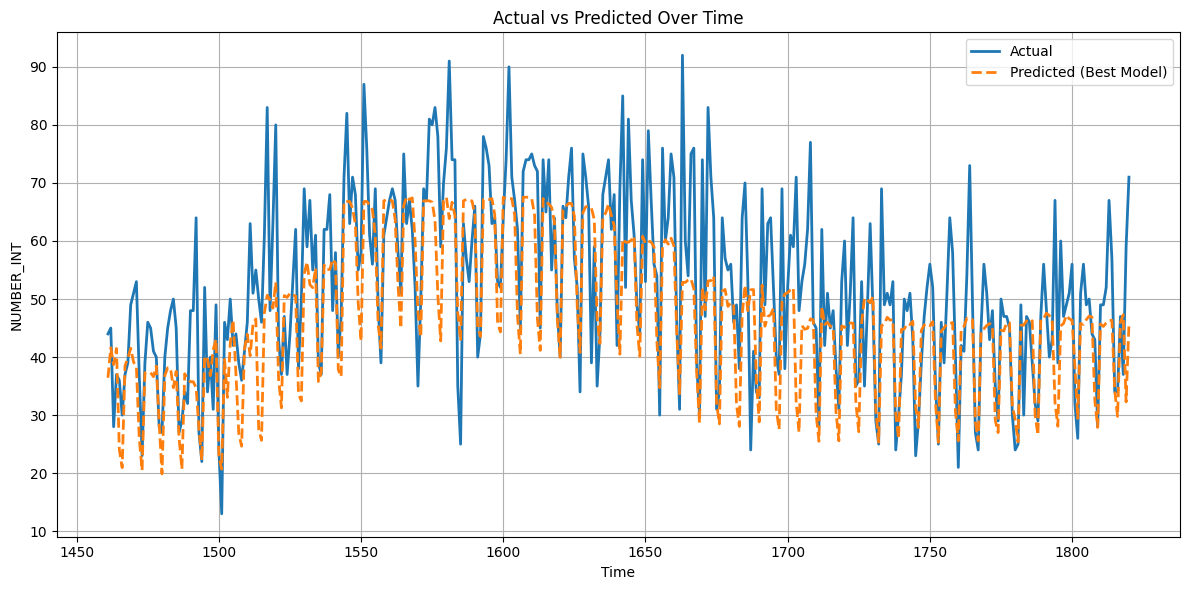

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

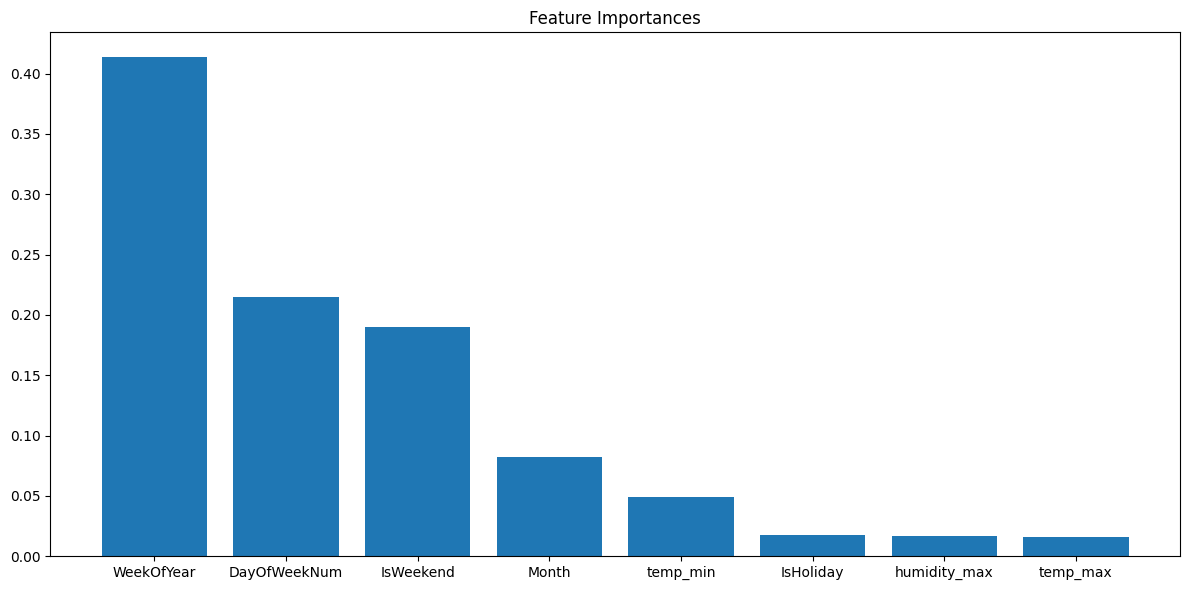

In [8]:
importances = best_rf_model_base.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices])
plt.tight_layout()
plt.show()

In [9]:
importances[indices]

array([0.41355776, 0.21510835, 0.19030288, 0.08203985, 0.04886889,
       0.01772122, 0.01689043, 0.01551062])

# Pointwise - CONFIVE

In [10]:
# Scaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

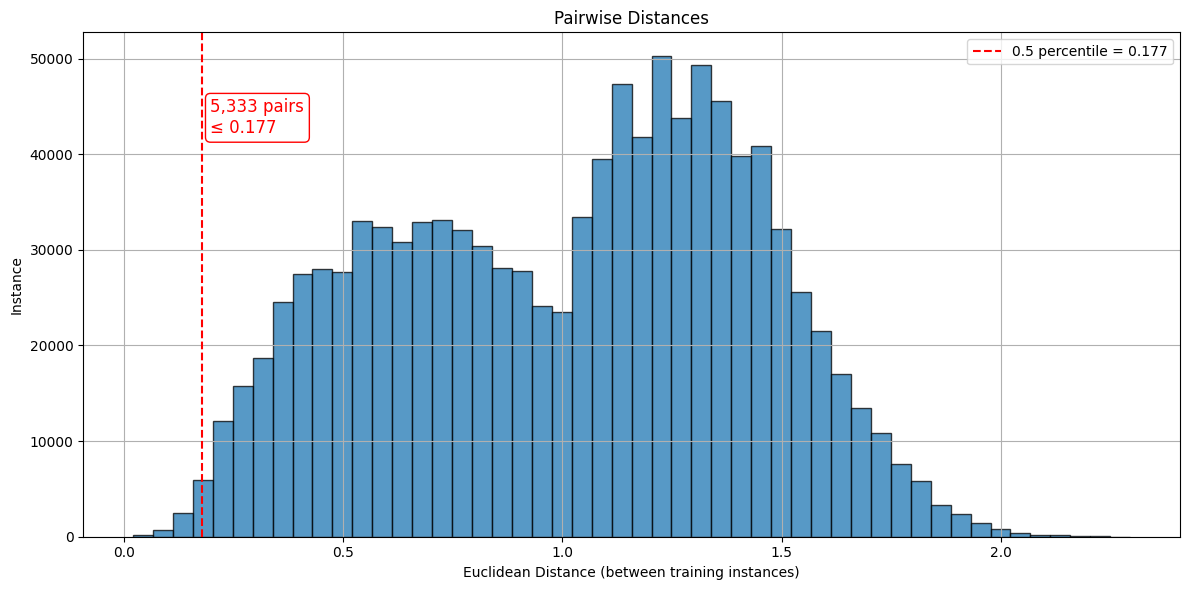

In [11]:
# Pairwise distances in training set
train_distance_matrix = euclidean_distances(X_train_scaled)
i_upper = np.triu_indices_from(train_distance_matrix, k=1)
pairwise_distances_train = train_distance_matrix[i_upper]

# TODO: select percentile (5th)
percentile_number = 0.5

selected_percentile = np.percentile(pairwise_distances_train, percentile_number)

count_below_percentile = np.sum(pairwise_distances_train <= selected_percentile)

plt.figure(figsize=(12, 6))
plt.hist(pairwise_distances_train, bins=50, edgecolor='black', alpha=0.75)
plt.axvline(selected_percentile, color='red', linestyle='--', label=f'{percentile_number} percentile = {selected_percentile:.3f}')
plt.text(selected_percentile + 0.02, plt.ylim()[1]*0.8,
         f'{count_below_percentile:,} pairs\n≤ {selected_percentile:.3f}',
         color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

plt.xlabel("Euclidean Distance (between training instances)")
plt.ylabel("Instance")
plt.title("Pairwise Distances")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
within_threshold = (train_distance_matrix <= selected_percentile)

np.fill_diagonal(within_threshold, False)

# Count neighbors within threshold for each instance
neighbors_within_threshold = np.sum(within_threshold, axis=1)

k_max = int(np.mean(neighbors_within_threshold))
distance_max = 0.177
k_max

7

# Setup

In [13]:
final_min_cluster_uni = 7

In [14]:
from sklearn.neighbors import NearestNeighbors

class ConfiveScorer:
    """
    CONFIVE scorer: Confidence estimation based on the variance
    of the labels of k-nearest neighbors by Briesemeister et al.
    """

    def __init__(self, X_train_scaled, y_train, k=7):
        self.X_train_scaled = np.asarray(X_train_scaled)
        self.y_train = np.asarray(y_train)
        self.k = k

        # Fit nearest neighbor model
        self.nn = NearestNeighbors(n_neighbors=self.k)
        self.nn.fit(self.X_train_scaled)

        # Pre-compute training CONFIVE scores
        self.train_confive_scores = np.array([
            self._compute_confive(self.X_train_scaled[i])
            for i in range(len(self.X_train_scaled))
        ])

    def _compute_confive(self, x_scaled):
        """
        Raw CONFIVE score based on variance of labels in k-nearest neighbors.
        Formula:
            ρ(x*) = 1 - (1 / (k-1)) * sum((ȳ - y_i)^2)
        """
        # NearestNeighbors, expect input arrays of shape (n_samples, n_features). scoring a single instance — a 1D array.
        x_scaled = x_scaled.reshape(1, -1)
        _, indices = self.nn.kneighbors(x_scaled, n_neighbors=self.k)
        neighbor_targets = self.y_train[indices[0]]
        y_bar = neighbor_targets.mean()
        variance = ((neighbor_targets - y_bar) ** 2).sum() / (self.k - 1)
        confive = 1 - variance
        return confive

    def score(self, x_scaled):
        """
        Normalized confidence score of x_scaled based on the percentile rank
        of its raw CONFIVE score compared to training CONFIVE scores.
        """
        raw_score = self._compute_confive(x_scaled)
        count = np.sum(self.train_confive_scores < raw_score)
        normalized = count / len(self.train_confive_scores)
        return normalized


In [15]:
confive = ConfiveScorer(X_train_scaled=X_train_scaled, y_train=y_train, k=final_min_cluster_uni)

# Compute CONFIVE normalized scores for validation set
confive_scores_val = np.array([confive.score(x) for x in X_val_scaled.values])

In [16]:
# Compute distance method
# Parameters
distance_threshold = distance_max
k = k_max
print(k_max)
print(distance_max)


nn_model_density = NearestNeighbors(n_neighbors=k).fit(X_train_scaled)
distances, _ = nn_model_density.kneighbors(X_val_scaled)

# Compute density: proportion of neighbors within distance_threshold
density_scores_val = np.minimum((distances <= distance_threshold).sum(axis=1) / k, 1)

# --- Combine with CONFIVE scores ---
final_reliability_scores = confive_scores_val * density_scores_val


7
0.177


In [17]:
distances

array([[0.20345152, 0.4284533 , 0.46112215, ..., 0.59840827, 0.60602331,
        0.62549812],
       [0.07747459, 0.09614105, 0.13549036, ..., 0.1726552 , 0.17323505,
        0.17880749],
       [0.11120081, 0.12498325, 0.14296424, ..., 0.16956362, 0.17971687,
        0.1813131 ],
       ...,
       [0.14393719, 0.15354838, 0.17518708, ..., 0.18610365, 0.19073733,
        0.20069817],
       [0.18242179, 0.23528536, 0.30617327, ..., 0.3767598 , 0.37888286,
        0.40201967],
       [0.03951956, 0.05243899, 0.08043576, ..., 0.16938535, 0.16983372,
        0.17394247]], shape=(360, 7))

In [18]:
df_val_with_confive = df_val.copy()
df_val_with_confive["CONFIVE"] = final_reliability_scores

# Add predictions and errors for downstream analysis
df_val_with_confive["y_true"] = y_val.values
df_val_with_confive["y_pred"] = y_pred
df_val_with_confive["abs_error"] = np.abs(df_val_with_confive["y_true"] - df_val_with_confive["y_pred"])


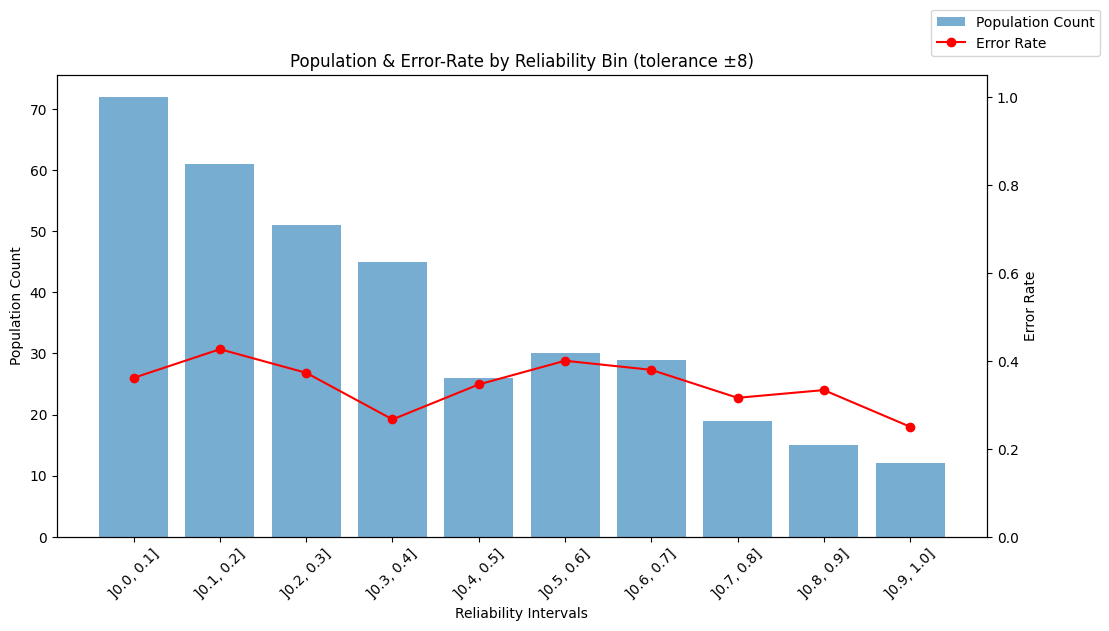

In [19]:
# ------------------------------------------------------------------
# CONFIVE reliability vs. error-rate plot
# ------------------------------------------------------------------

tolerance = 8  # TODO acceptable absolute-error band


# Assemble a DataFrame for analysis
df_plot = df_val.copy()
df_plot["y_true"] = y_val.values
df_plot["y_pred"] = y_pred
df_plot["abs_error"] = np.abs(df_plot["y_true"] - df_plot["y_pred"])
df_plot["correct"] = df_plot["abs_error"] <= tolerance
df_plot["Reliability"] = final_reliability_scores

# Bin reliability into deciles
bins = np.linspace(0, 1, 11) # 0.0, 0.1, ... , 1.0
labels = [f"]{bins[i]:.1f}, {bins[i+1]:.1f}]" for i in range(len(bins)-1)]
df_plot["reliability_bin"] = pd.cut(
    df_plot["Reliability"], bins=bins,
    labels=labels, include_lowest=True
)

# Aggregate
grouped = df_plot.groupby("reliability_bin", observed=True)
pop_count = grouped.size()
error_rate = 1 - grouped["correct"].sum() / pop_count

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pop_count.index, pop_count.values,
        alpha=0.6, label="Population Count")
ax1.set_ylabel("Population Count")
ax1.set_xlabel("Reliability Intervals")
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(error_rate.index, error_rate.values,
         marker='o', color='red', label="Error Rate")
ax2.set_ylabel("Error Rate")
ax2.set_ylim(0, 1.05)

plt.title(f"Population & Error-Rate by Reliability Bin (tolerance ±{tolerance})")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1))

# plt.tight_layout()
plt.show()

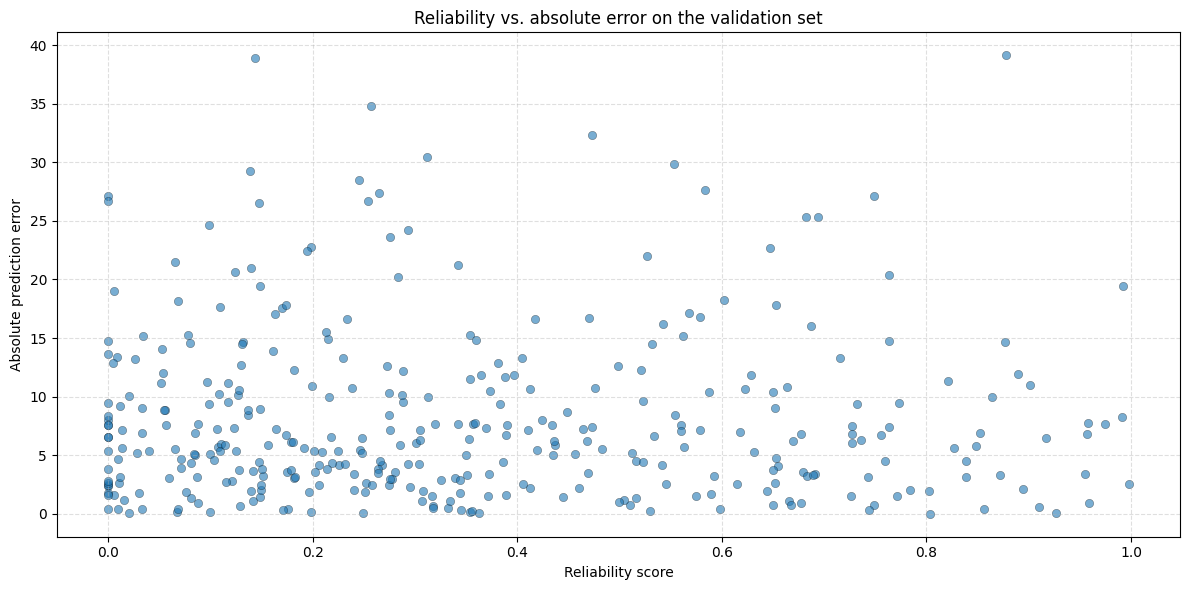

In [20]:
# ---------------------------------------------------------------
# Scatter: Reliability vs. absolute prediction error
# ---------------------------------------------------------------

errors = np.abs(y_val.values - y_pred)

df_re_err = pd.DataFrame({
    "Reliability": final_reliability_scores,
    "AbsError"   : errors,
})

plt.figure(figsize=(12, 6))
plt.scatter(df_re_err["Reliability"],
            df_re_err["AbsError"],
            alpha=0.6, edgecolor="k", linewidth=0.3)
plt.xlabel("Reliability score")
plt.ylabel("Absolute prediction error")
plt.title("Reliability vs. absolute error on the validation set")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
